# Predicting Categories for Amazon Products

### Abstract

The purpose of this work is to make a predictor which would act as automatic categorizer in online shops. It would work like this: an user wants to sell his watch, so he/she takes a picture of it and uploads it to website, which then suggests categories where similar items (in this case) watches usually go and where people would most likely look for them.

## Reading in the metainfo about the dataset

The dataset is provided by Amazon and it's root category where all products fit into is "Clothing_Shoes_and_Jewelry")

In [8]:
import pandas as pd
data = pd.read_csv("images_to_download.csv", header=None, names=['Category','Index', 'ID', 'imUrl'])

In [35]:
from os import listdir
from os.path import isfile, join

mypath = './Images'
onlyfiles = [int(f.replace(".jpg","")) for f in listdir(mypath) if isfile(join(mypath, f))]

In [9]:
#get available images
data = data[data['Index'].isin(onlyfiles)]

In [10]:
data['Category'].value_counts()

Wallets            3000
Shoes              3000
Scarves & Wraps    3000
Socks              3000
Masks              3000
Backpacks          3000
Belts              2999
Pants              2999
Bras               2999
Underwear          2999
Coats & Jackets    2998
Watches            2998
Hats & Caps        2997
T-Shirts           2997
Luggage            2996
Jewelry            2977
Name: Category, dtype: int64

## Dividing dataset into test and train sets

Divide images into training, test and validation sets in stratified fashion.

In [51]:
import numpy as np

train_indices = []
validation_indices = []
test_indices = []

for name, group in data.groupby('Category'):
    # 90% training, 10% test
    train_size = int(group.shape[0] *0.9)
    
    
    sub_train = np.random.choice(group.index, train_size, replace=False)
    test_indices.extend(np.setdiff1d(group.index, sub_train))

    # 80% of training as training set and 20% validation set
    val_size = int(train_size *0.2) 
    validation_sub = np.random.choice(sub_train, val_size, replace=False)

    train_indices.extend(np.setdiff1d(sub_train, validation_sub))
    validation_indices.extend(validation_sub)
    
train_indices = np.array(train_indices)
test_indices = np.array(test_indices)
validation_indices = np.array(validation_indices)    


In [52]:
train_indices.shape, test_indices.shape, validation_indices.shape

((34535,), (4798,), (8626,))

## Move images into specific folders

### Create folders

Make separate test, train and validation folders.

In [55]:
import os

try:
    os.makedirs("./train")
except:
    print("directory already exists")
    
try:
    os.makedirs("./val")
except:
    print("directory already exists")
    
try:
    os.makedirs("./test")
except:
    print("directory already exists")


### Create separate folder for each category

I use ImageDataGenerator which let's to read images in batches straight from directory during training and testing but in order for it to work each image has to be in certain subfolder containing only this category images. This is why I could only use products which belong into just one category.
 

In [57]:
import os
import shutil
src = "./Images/"

# target_dir = os.listdir(target)


def move_files(indices, target_folder):
    # create subfolders
    for category in data.loc[indices]['Category'].unique():
        try:
            os.makedirs(target_folder + category)
        except:
            print("directory already exists")

    for name, group in data.loc[indices].groupby("Category"):
        sub_dir = os.listdir(target_folder + name)
        for index in group['Index']:
            file_name = str(index) + ".jpg"
            full_file_name = os.path.join(src, file_name)
            if(file_name not in sub_dir):
                try:
                    shutil.copy(full_file_name, target_folder + name)
                except:
                    print(full_file_name)
for indices, target in zip([train_indices, test_indices, validation_indices], ['./train/','./test/','./val/']):

    move_files(indices,target)


directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
directory already exists
./Images/248144.jpg
./Images/30339.jpg


## Display some example images from each category

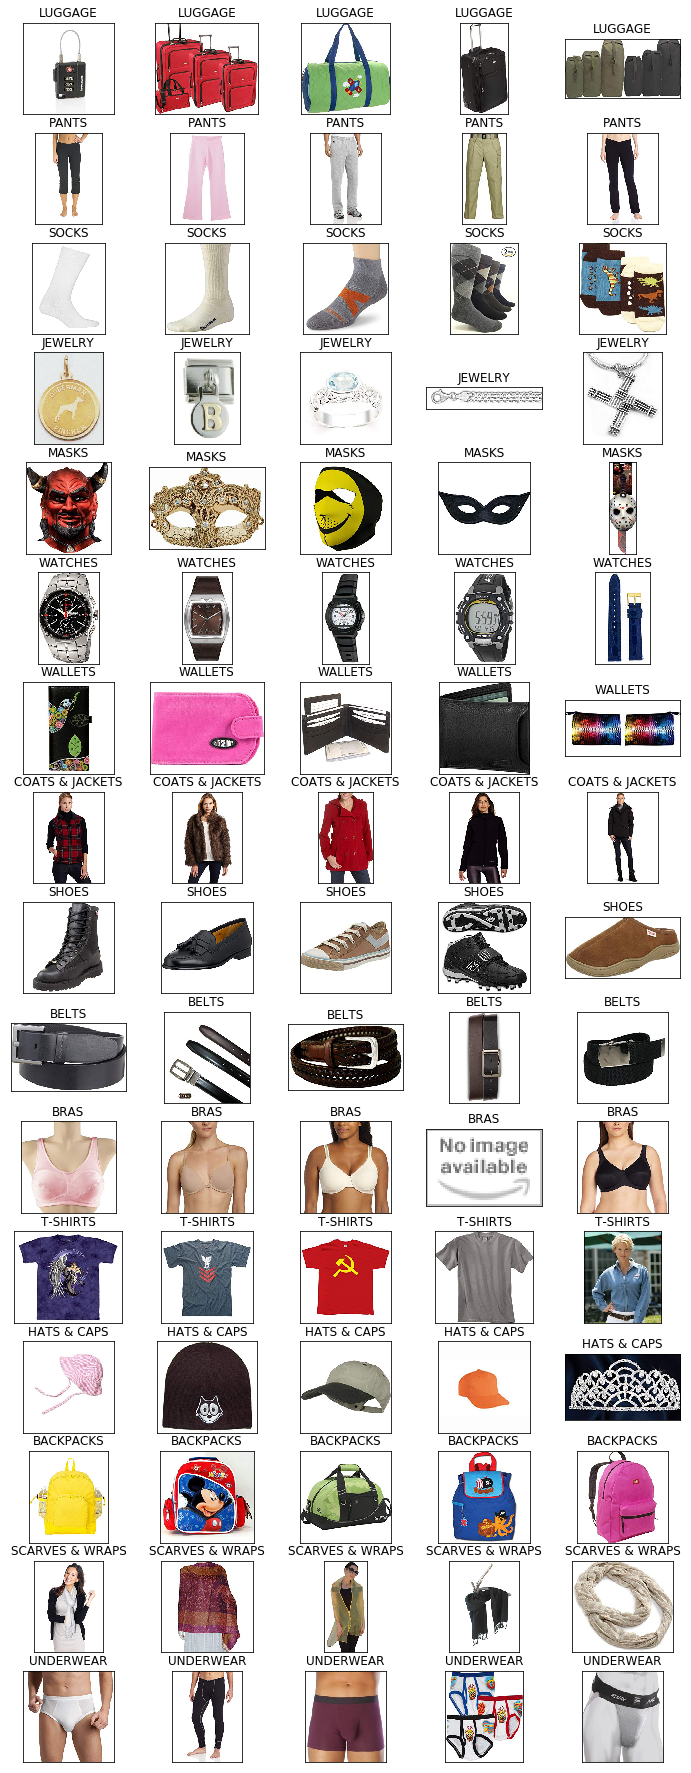

In [58]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import string

path_to_dir_with_label_dirs = './train'

list_of_labels = os.listdir(path_to_dir_with_label_dirs)

fig, axes = plt.subplots(len(list_of_labels),5, figsize=(12,32))

for r, label in enumerate(list_of_labels):
    current_label_dir_path = os.path.join(path_to_dir_with_label_dirs, label)
    list_of_images = os.listdir(current_label_dir_path)
    for c, image in enumerate(list_of_images[10:15]):
        current_image_path = os.path.join(current_label_dir_path, image)
        img = mpimg.imread(current_image_path)
        imgplot = axes[r][c].imshow(img)
        axes[r][c].get_xaxis().set_ticks([])
        axes[r][c].get_yaxis().set_ticks([])
        axes[r][c].set_title(label.upper())

plt.show()


## Get sizes of images

Images are not the same shape, so I found the median shape for most optimal shape to scale images into.

In [ ]:
onlyfiles

In [59]:
from PIL import Image

xs = []
ys = []

for image in onlyfiles:
    try:
        (x,y) =  Image.open('./Images/' + str(image) + '.jpg').size
        xs.append(x)
        ys.append(y)
    except:
        import os
        if os.path.exists('./Images/' + str(image) + '.jpg'):
            os.remove('./Images/' + str(image) + '.jpg')
        else:
            print('./Images/' + str(image) + '.jpg')


./Images/248144.jpg
./Images/30339.jpg


In [60]:
import numpy as np
xs = np.array(xs)
ys = np.array(ys)


In [61]:
np.median(xs), np.median(ys)

(342.0, 342.0)

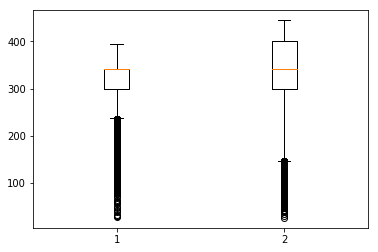

In [62]:
from matplotlib.pyplot import boxplot
import matplotlib.pyplot as plt


boxplot([xs,ys])
plt.show()

## Make data generators

These generators let's to read train images straight from directory and replaces the need to read every image into cache. 

In [1]:
from keras.preprocessing.image import ImageDataGenerator

input_shape = (180,180)

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        './train/',
        target_size= input_shape,
        batch_size=64,
        class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
        './val/',
        target_size=input_shape,
        batch_size=64,
        class_mode='sparse')
test_generator = test_datagen.flow_from_directory(
        './test/',
        target_size=input_shape,
        batch_size=64,
        class_mode='sparse')

/home/egert/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Found 34534 images belonging to 16 classes.
Found 8625 images belonging to 16 classes.
Found 4798 images belonging to 16 classes.


## Define a network 1 — 1-Conv CNN

In [9]:
import keras
regulizer = keras.regularizers.l1(0.01)

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [103]:
input_shape = (180,180,3)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D


cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=regulizer))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l1(0.002)))
cnn1.add(Dense(16, activation='softmax'))

cnn1.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 89, 89, 32)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 89, 89, 32)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 253472)            0         
_________________________________________________________________
dense_26 (Dense)             (None, 64)                16222272  
_________________________________________________________________
dense_27 (Dense)             (None, 16)                1040      
Total params: 16,224,208
Trainable params: 16,224,208
Non-trainable params: 0
________________________________________________________________

In [104]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

cnn1.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=120)

Epoch 1/5
200/200 [==============================] - 362s 2s/step - loss: 20.9412 - acc: 0.0632 - val_loss: 12.1187 - val_acc: 0.0671
Epoch 2/5
200/200 [==============================] - 343s 2s/step - loss: 12.0600 - acc: 0.0626 - val_loss: 12.2865 - val_acc: 0.0678
Epoch 3/5
200/200 [==============================] - 341s 2s/step - loss: 12.0407 - acc: 0.0622 - val_loss: 12.0829 - val_acc: 0.0613
Epoch 4/5
200/200 [==============================] - 5616s 28s/step - loss: 12.0241 - acc: 0.0602 - val_loss: 12.0642 - val_acc: 0.0618
Epoch 5/5
200/200 [==============================] - 440s 2s/step - loss: 12.0214 - acc: 0.0627 - val_loss: 12.2415 - val_acc: 0.0603


In [105]:
probabilities = cnn1.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

In [106]:
import numpy as np
from sklearn.metrics import accuracy_score

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

0.06252605252188412

In [107]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
# probabilities = cnn1.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes)

confusion_matrix(test_generator.classes,np.argmax(probabilities, axis=1))

array([[300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [298,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0],
       [300,   0,   0,   0,   

### Regularization 0.1

## 3 — 4-Conv CNN

In [7]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization


input_shape = (180,180,3)
cnn4 = Sequential()
cnn4.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn4.add(BatchNormalization())

cnn4.add(Conv2D(16, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.25))

cnn4.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(MaxPooling2D(pool_size=(2, 2)))
cnn4.add(Dropout(0.25))

cnn4.add(Flatten())

cnn4.add(Dense(32, activation='relu'))
cnn4.add(BatchNormalization())
cnn4.add(Dropout(0.2))

cnn4.add(Dense(16, activation='softmax'))

cnn4.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])
cnn4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 178, 178, 16)      448       
_________________________________________________________________
batch_normalization_7 (Batch (None, 178, 178, 16)      64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 176, 176, 16)      2320      
_________________________________________________________________
batch_normalization_8 (Batch (None, 176, 176, 16)      64        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 88, 88, 16)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 88, 88, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 86, 86, 64)        9280      
__________

In [10]:
cnn4.fit_generator(
        train_generator,
        steps_per_epoch=200,
        epochs=5,
        validation_data=validation_generator,
        validation_steps=100)

Epoch 1/5
200/200 [==============================] - 1577s 8s/step - loss: 1.7123 - acc: 0.4993 - val_loss: 2.2271 - val_acc: 0.4558
Epoch 2/5
200/200 [==============================] - 1560s 8s/step - loss: 1.4568 - acc: 0.5713 - val_loss: 1.7286 - val_acc: 0.5637
Epoch 3/5
200/200 [==============================] - 1553s 8s/step - loss: 1.3660 - acc: 0.5997 - val_loss: 10.9883 - val_acc: 0.1435
Epoch 4/5
200/200 [==============================] - 1553s 8s/step - loss: 1.3009 - acc: 0.6147 - val_loss: 1.8891 - val_acc: 0.5092
Epoch 5/5
200/200 [==============================] - 1549s 8s/step - loss: 1.2128 - acc: 0.6384 - val_loss: 1.2047 - val_acc: 0.6606


In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
# probabilities = cnn4.predict_generator(test_generator, steps=len(test_generator.filenames) /64)

accuracy_score(np.argmax(probabilities, axis=1), test_generator.classes),confusion_matrix(test_generator.classes, np.argmax(probabilities, axis=1))

(0.0637765735723218,
 array([[23, 17, 18, 16, 21, 41, 17,  8, 16, 13, 26,  8, 21, 17, 16, 22],
        [14, 21, 19, 30, 15, 38, 17, 13, 19, 13, 22, 12, 15, 11, 22, 19],
        [21, 18, 15, 21, 20, 48, 15, 11, 15, 16, 21, 16, 23,  8, 15, 17],
        [23, 16, 13, 29, 18, 41, 24, 14, 15, 13, 19, 15, 19, 13, 11, 17],
        [19, 17, 17, 23, 18, 53, 17, 10, 20, 17, 24, 16, 11,  6, 11, 21],
        [32, 20, 14, 17, 22, 47, 15, 16, 14, 15, 17, 17, 14, 10, 11, 17],
        [25, 20, 29, 30, 14, 38,  9, 11, 16, 13, 17, 15, 20, 16, 11, 16],
        [21, 17, 15, 32, 13, 40, 10, 14, 22, 18, 31,  6, 21, 12, 11, 17],
        [27, 27, 17, 30, 17, 37, 13, 10, 18, 13, 22, 13, 17, 13, 10, 16],
        [31, 17, 15, 23, 25, 35, 16, 10, 27, 16, 19, 15, 11, 12,  8, 20],
        [27, 20, 12, 24, 18, 45, 18,  3, 19, 15, 19, 17, 19, 10, 16, 18],
        [26, 24, 12, 23, 27, 37, 12, 11, 22, 13, 23, 14, 12,  9, 15, 20],
        [19, 28, 14, 20, 23, 49, 11, 12, 19,  9, 17, 12, 17, 12, 18, 20],
        [23, 22, 

As can be seen, the model still seriously overfitted because high accuracy on training and validation set but accuracy close to random guessing on test set.